# 预测 AR(1) 过程

In [1]:
!pip install arviz pymc

本讲座介绍了用于预测单变量自回归过程未来值函数的统计方法。

这些方法旨在考虑这些统计数据的两个可能的不确定性来源：

- 影响转换规律的随机冲击

- AR(1)过程参数值的不确定性

我们考虑两类统计量：

- 由AR(1)过程控制的随机过程{y_t}的预期值y_{t+j}

- 在时间t定义为未来值{y_{t+j}}_{j ≥ 1}的非线性函数的样本路径特性

**样本路径特性**是指诸如"到下一个转折点的时间"或"到下一次衰退的时间"之类的特征。

为研究样本路径特性，我们将使用Wecker {cite}`wecker1979predicting`推荐的模拟程序。

为了考虑参数的不确定性，我们将使用`pymc`构建未知参数的贝叶斯联合后验分布。
让我们从一些导入开始。

In [2]:
import numpy as np
import arviz as az
import pymc as pmc
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

import seaborn as sns

sns.set_style('white')
colors = sns.color_palette()

import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)

## 一元一阶自回归过程

考虑一元AR(1)模型：

$$ 
y_{t+1} = \rho y_t + \sigma \epsilon_{t+1}, \quad t \geq 0 
$$ (ar1-tp-eq1) 

其中标量$\rho$和$\sigma$满足$|\rho| < 1$和$\sigma > 0$；
$\{\epsilon_{t+1}\}$是一个均值为$0$、方差为$1$的独立同分布正态随机变量序列。

初始条件$y_{0}$是一个已知数。

方程{eq}`ar1-tp-eq1`表明对于$t \geq 0$，$y_{t+1}$的条件密度为

$$
f(y_{t+1} | y_{t}; \rho, \sigma) \sim {\mathcal N}(\rho y_{t}, \sigma^2) \
$$ (ar1-tp-eq2)

此外，方程{eq}`ar1-tp-eq1`还表明对于$t \geq 0$，$y_{t+j}$（其中$j \geq 1$）的条件密度为

$$
f(y_{t+j} | y_{t}; \rho, \sigma) \sim {\mathcal N}\left(\rho^j y_{t}, \sigma^2 \frac{1 - \rho^{2j}}{1 - \rho^2} \right) 
$$ (ar1-tp-eq3)

预测分布{eq}`ar1-tp-eq3`假设参数$\rho, \sigma$是已知的，我们表示
通过对它们进行条件化。

我们还想计算一个不对$\rho,\sigma$进行条件化，而是考虑到它们的不确定性的预测分布。

我们通过将{eq}`ar1-tp-eq3`对联合后验分布$\pi_t(\rho,\sigma | y^t)$进行积分来形成这个预测分布，该后验分布基于观测历史$y^t = \{y_s\}_{s=0}^t$：

$$ 
f(y_{t+j} | y^t)  = \int f(y_{t+j} | y_{t}; \rho, \sigma) \pi_t(\rho,\sigma | y^t ) d \rho d \sigma
$$ (ar1-tp-eq4)

预测分布{eq}`ar1-tp-eq3`假设参数$(\rho,\sigma)$是已知的。

预测分布{eq}`ar1-tp-eq4`假设参数$(\rho,\sigma)$是不确定的，但有已知的概率分布$\pi_t(\rho,\sigma | y^t )$。

我们还想计算一些"样本路径统计量"的预测分布，这可能包括

- 到下一次"衰退"的时间，
- 未来8个周期内Y的最小值，
- "严重衰退"，以及
- 到下一个转折点（正或负）的时间。

为了在我们不确定参数值的情况下实现这一点，我们将按以下方式扩展Wecker的{cite}`wecker1979predicting`方法。

- 首先模拟一个长度为$T_0$的初始路径；
- 对于给定的先验分布，在观察初始路径后从参数$\left(\rho,\sigma\right)$的后验联合分布中抽取大小为$N$的样本；
- 对于每个抽样$n=0,1,...,N$，用参数$\left(\rho_n,\sigma_n\right)$模拟长度为$T_1$的"未来路径"，并计算我们的三个"样本路径统计量"；
- 最后，将$N$个样本的所需统计量绘制为经验分布。

## 实现

首先，我们将模拟一个样本路径，从这个路径开始进行预测。

除了绘制样本路径外，在假设已知真实参数值的情况下，我们将使用条件分布绘制$.9$和$.95$的覆盖区间
上述{eq}`ar1-tp-eq3`所描述的。

我们还将绘制一系列未来值序列的样本，并观察它们相对于覆盖区间的分布情况。

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

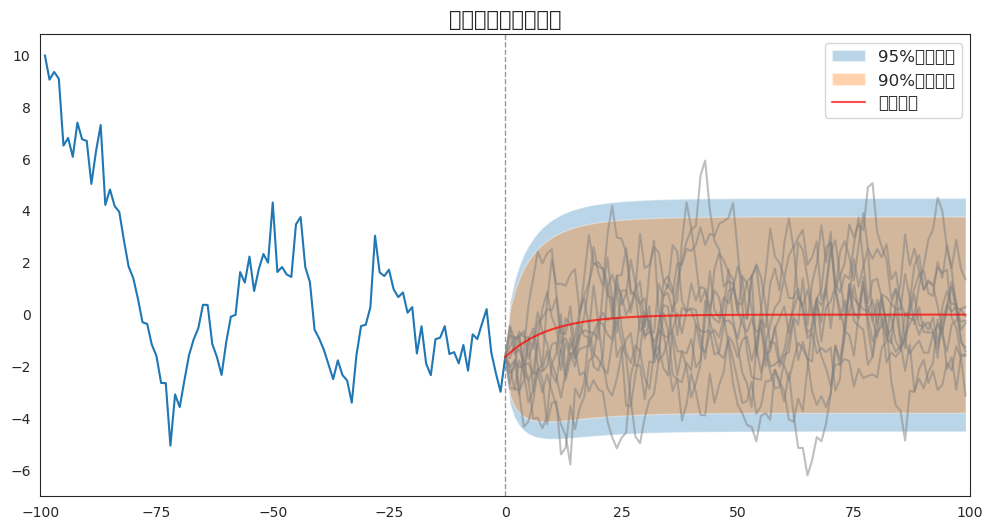

In [3]:
def AR1_simulate(rho, sigma, y0, T):

    # 分配空间并生成随机误差项
    y = np.empty(T)
    eps = np.random.normal(0, sigma, T)

    # 初始条件并向前推进
    y[0] = y0
    for t in range(1, T):
        y[t] = rho * y[t-1] + eps[t]
        
    return y


def plot_initial_path(initial_path):
    """
    绘制初始路径和前面的预测密度
    """
    # 计算0.9置信区间
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # 绘图
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title("初始路径和预测密度", fontsize=15)
    ax.plot(np.arange(-T0 + 1, 1), initial_path)
    ax.set_xlim([-T0, T1])
    ax.axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # 模拟未来路径
    for i in range(10):
        y_future = AR1_simulate(rho, sigma, y0, T1)
        ax.plot(np.arange(T1), y_future, color='grey', alpha=.5)
    
    # 绘制90%置信区间
    ax.fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3, label='95%置信区间')
    ax.fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35, label='90%置信区间')
    ax.plot(np.arange(T1), center, color='red', alpha=.7, label='期望均值')
    ax.legend(fontsize=12)
    plt.show()


sigma =  1
rho = 0.9
T0, T1 = 100, 100
y0 = 10

# 模拟
np.random.seed(145)
initial_path = AR1_simulate(rho, sigma, y0, T0)

# 绘图
plot_initial_path(initial_path)

作为预测期的函数，置信区间的形状类似于 https://python.quantecon.org/perm_income_cons.html 中所描述的。

## 路径属性的预测分布

Wecker {cite}`wecker1979predicting` 提出使用模拟技术来表征某些统计量的预测分布,这些统计量是 $y$ 的非线性函数。

他将这些函数称为"路径属性",以区别于单个数据点的属性。

他研究了给定序列 $\{y_t\}$ 的两个特殊的前瞻性路径属性。

第一个是**到下一个转折点的时间**。

* 他将**"转折点"**定义为 $y$ 连续两次下降中的第二个时间点。

为了研究这个统计量,让 $Z$ 作为一个指示过程

<!-- $$
Z_t(Y(\omega)) := \left\{ 
\begin{array} {c}
\ 1 & \text{if } Y_t(\omega)< Y_{t-1}(\omega)< Y_{t-2}(\omega) \geq Y_{t-3}(\omega) \\
0 & \text{otherwise}
\end{array} \right.
$$ -->

$$
Z_t(Y(\omega)) :=  
\begin{cases}
\ 1 & \text{如果 } Y_t(\omega)< Y_{t-1}(\omega)< Y_{t-2}(\omega) \geq Y_{t-3}(\omega) \\
0 & \text{其他情况}
\end{cases} 
$$

那么**到下一个转折点的时间**这个随机变量被定义为关于$Z$的以下**停时**:

$$
W_t(\omega):= \inf \{ k\geq 1 \mid Z_{t+k}(\omega) = 1\}
$$

Wecker {cite}`wecker1979predicting`还研究了**未来8个季度$Y$的最小值**,可以定义为随机变量:

$$ 
M_t(\omega) := \min \{ Y_{t+1}(\omega); Y_{t+2}(\omega); \dots; Y_{t+8}(\omega)\}
$$

研究另一个可能的**转折点**概念也很有意思。

因此,令
<!-- 
$$
T_t(Y(\omega)) := \left\{ 
\begin{array}{c}
\ 1 & \text{如果 } Y_{t-2}(\omega)> Y_{t-1}(\omega) > Y_{t}(\omega) \ \text{且 } \ Y_{t}(\omega) < Y_{t+1}(\omega) < Y_{t+2}(\omega) \\
\ -1 & \text{如果 } Y_{t-2}(\omega)< Y_{t-1}(\omega) < Y_{t}(\omega) \ \text{且 } \ Y_{t}(\omega) > Y_{t+1}(\omega) > Y_{t+2}(\omega) \\
0 & \text{其他情况}
\end{array} \right.
$$ -->


$$
T_t(Y(\omega)) := 
\begin{cases}
\ 1 & \text{如果 } Y_{t-2}(\omega)> Y_{t-1}(\omega) > Y_{t}(\omega) \ \text{且 } \ Y_{t}(\omega) < Y_{t+1}(\omega) < Y_{t+2}(\omega) \\
\ -1 & \text{如果 } Y_{t-2}(\omega)< Y_{t-1}(\omega) < Y_{t}(\omega) \ \text{且 } \ Y_{t}(\omega) > Y_{t+1}(\omega) > Y_{t+2}(\omega) \\
0 & \text{其他情况}
\end{cases}
$$

定义**今天或明天的正转折点**统计量为

<!-- $$
P_t(\omega) := \left\{ 
\begin{array}{c}
\ 1 & \text{如果 } T_t(\omega)=1 \ \text{或} \ T_{t+1}(\omega)=1 \\
0 & \text{其他情况}
\end{array} \right.
$$ -->


$$
P_t(\omega) := 
\begin{cases}
\ 1 & \text{如果 } T_t(\omega)=1 \ \text{或} \ T_{t+1}(\omega)=1 \\
0 & \text{其他情况}
\end{cases}
$$

这被设计用来表示以下事件：

- "在一次或两次下降之后，$Y$ 将连续两个季度增长"

根据{cite}`wecker1979predicting`，我们可以通过模拟来计算每个时期 $t$ 的 $P_t$ 和 $N_t$ 的概率。
## 类韦克算法

该过程包含以下步骤：

* 用 $\omega_i$ 标记样本路径

* 对于给定日期 $t$，模拟 $I$ 条长度为 $N$ 的样本路径

$$
Y(\omega_i) = \left\{ Y_{t+1}(\omega_i), Y_{t+2}(\omega_i), \dots, Y_{t+N}(\omega_i)\right\}_{i=1}^I
$$

* 对每条路径 $\omega_i$，计算相应的 $W_t(\omega_i), W_{t+1}(\omega_i), \dots$ 值

* 将集合 $\{W_t(\omega_i)\}^{T}_{i=1}, \ \{W_{t+1}(\omega_i)\}^{T}_{i=1}, \ \dots, \ \{W_{t+N}(\omega_i)\}^{T}_{i=1}$ 视为来自预测分布 $f(W_{t+1} \mid \mathcal y_t, \dots)$, $f(W_{t+2} \mid y_t, y_{t-1}, \dots)$, $\dots$, $f(W_{t+N} \mid y_t, y_{t-1}, \dots)$ 的样本。

## 使用模拟来近似后验分布

下面的代码单元使用 `pymc` 计算时间 $t$ 时 $\rho, \sigma$ 的后验分布。

注意在定义似然函数时，我们选择以初始值 $y_0$ 为条件。

Output()

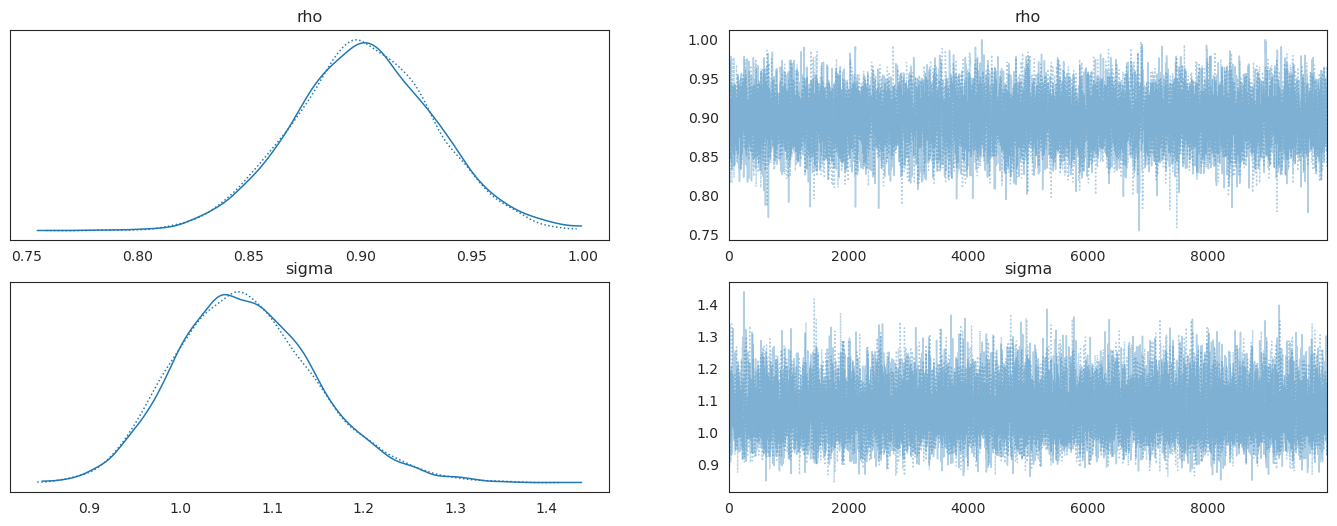

In [4]:
def draw_from_posterior(sample):
    """
    从后验分布中抽取大小为N的样本。
    """

    AR1_model = pmc.Model()

    with AR1_model:
        
        # 从先验开始
        rho = pmc.Uniform('rho',lower=-1.,upper=1.)  # 假设rho稳定
        sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

        # 下一期y的期望值(rho * y)
        yhat = rho * sample[:-1]

        # 实际实现值的似然
        y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=sample[1:])

    with AR1_model:
        trace = pmc.sample(10000, tune=5000)

    # 检查条件
    with AR1_model:
        az.plot_trace(trace, figsize=(17, 6))
    
    rhos = trace.posterior.rho.values.flatten()
    sigmas = trace.posterior.sigma.values.flatten()

    post_sample = {
        'rho': rhos,
        'sigma': sigmas
    }
    
    return post_sample

post_samples = draw_from_posterior(initial_path)

左侧的图表展示了后验边际分布。

## 计算样本路径统计量

接下来我们准备Python代码来计算我们的样本路径统计量。

In [5]:
# 定义统计量
def next_recession(omega):
    n = omega.shape[0] - 3
    z = np.zeros(n, dtype=int)
    
    for i in range(n):
        z[i] = int(omega[i] <= omega[i+1] and omega[i+1] > omega[i+2] and omega[i+2] > omega[i+3])

    if np.any(z) == False:
        return 500
    else:
        return np.where(z==1)[0][0] + 1

def minimum_value(omega):
    return min(omega[:8])

def severe_recession(omega):
    z = np.diff(omega)
    n = z.shape[0]
    
    sr = (z < -.02).astype(int)
    indices = np.where(sr == 1)[0]

    if len(indices) == 0:
        return T1
    else:
        return indices[0] + 1

def next_turning_point(omega):
    """
    假设omega的长度为6
    
        y_{t-2}, y_{t-1}, y_{t}, y_{t+1}, y_{t+2}, y_{t+3}
    
    这足以确定P/N的值    
    """
    
    n = np.asarray(omega).shape[0] - 4
    T = np.zeros(n, dtype=int)
    
    for i in range(n):
        if ((omega[i] > omega[i+1]) and (omega[i+1] > omega[i+2]) and 
            (omega[i+2] < omega[i+3]) and (omega[i+3] < omega[i+4])):
            T[i] = 1
        elif ((omega[i] < omega[i+1]) and (omega[i+1] < omega[i+2]) and 
            (omega[i+2] > omega[i+3]) and (omega[i+3] > omega[i+4])):
            T[i] = -1
    
    up_turn = np.where(T == 1)[0][0] + 1 if (1 in T) == True else T1
    down_turn = np.where(T == -1)[0][0] + 1 if (-1 in T) == True else T1

    return up_turn, down_turn

## 原始韦克方法

现在我们通过模拟未来路径并计算预测分布来应用韦克的原始方法，这些预测分布以数据生成模型相关的真实参数为条件。

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

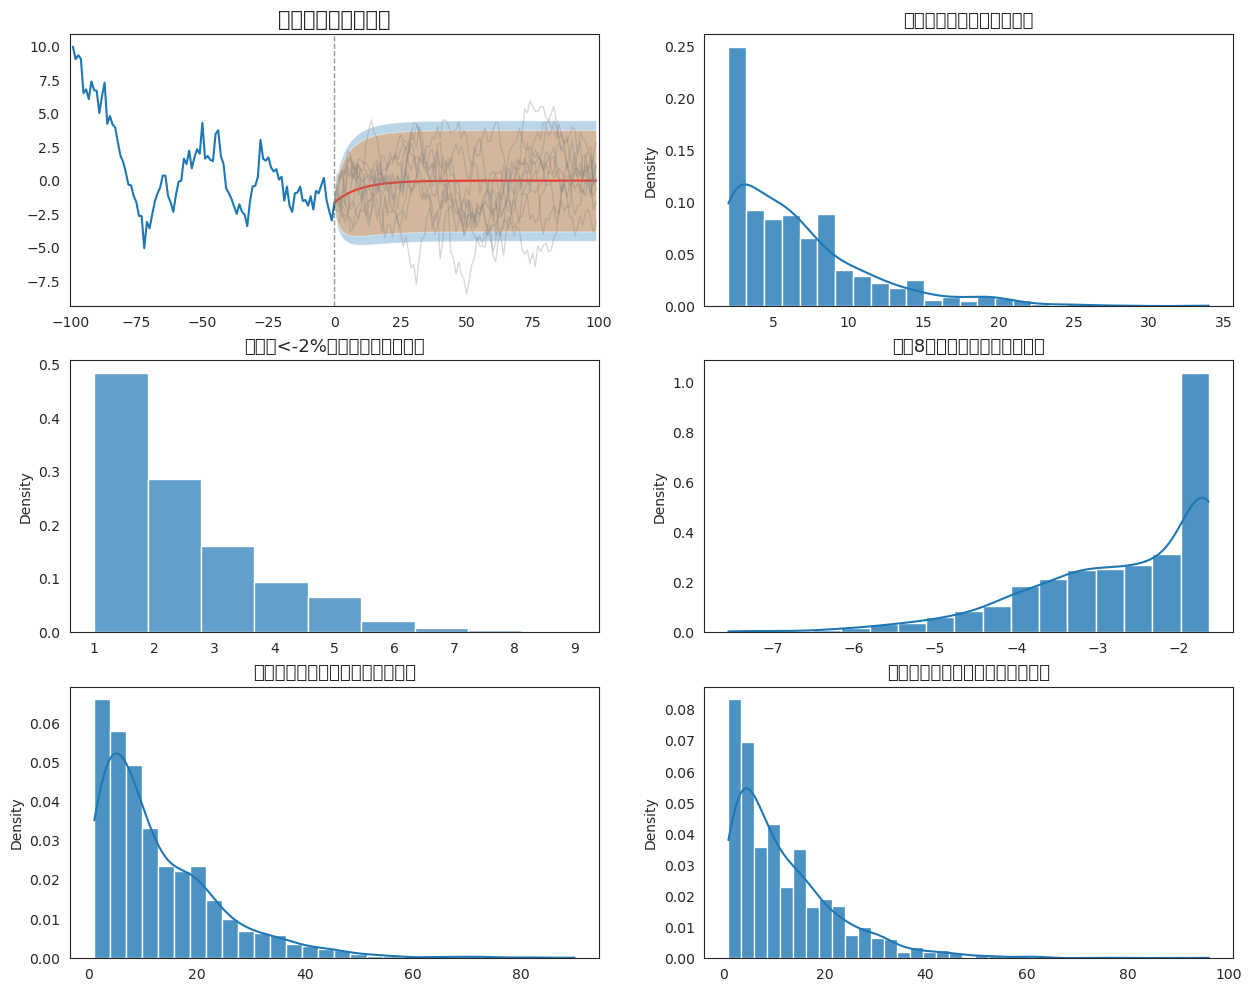

In [6]:
def plot_Wecker(initial_path, N, ax):
    """
    绘制"纯"韦克方法的预测分布。
    """
    # 存储结果
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)
    
    # 计算0.9置信区间
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # 绘图
    ax[0, 0].set_title("初始路径和预测密度", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # 绘制90%置信区间
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3)
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35)
    ax[0, 0].plot(np.arange(T1), center, color='red', alpha=.7)

    # 模拟未来路径
    for n in range(N):
        sim_path = AR1_simulate(rho, sigma, initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n%(N/10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
            
    # 返回next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.8, label='真实参数')
    ax[0, 1].set_title("下一次衰退时间的预测分布", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=0.9, alpha=.7, label='真实参数')
    ax[1, 0].set_title(r"增长率<-2%的停止时间预测分布", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.8, label='真实参数')
    ax[1, 1].set_title("未来8个周期最小值的预测分布", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.8, label='真实参数')
    ax[2, 0].set_title("下一个正向转折点时间的预测分布", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.8, label='真实参数')
    ax[2, 1].set_title("下一个负向转折点时间的预测分布", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
plt.show()

## 扩展 Wecker 方法

现在我们应用基于 {eq}`ar1-tp-eq4` 定义的 $y$ 的预测密度的"扩展" Wecker 方法，该方法考虑了参数 $\rho, \sigma$ 的后验不确定性。

为了近似 {eq}`ar1-tp-eq4` 右侧的积分，我们每次从联合后验分布中重复抽取参数，同时从模型 {eq}`ar1-tp-eq1` 中模拟未来值序列。

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

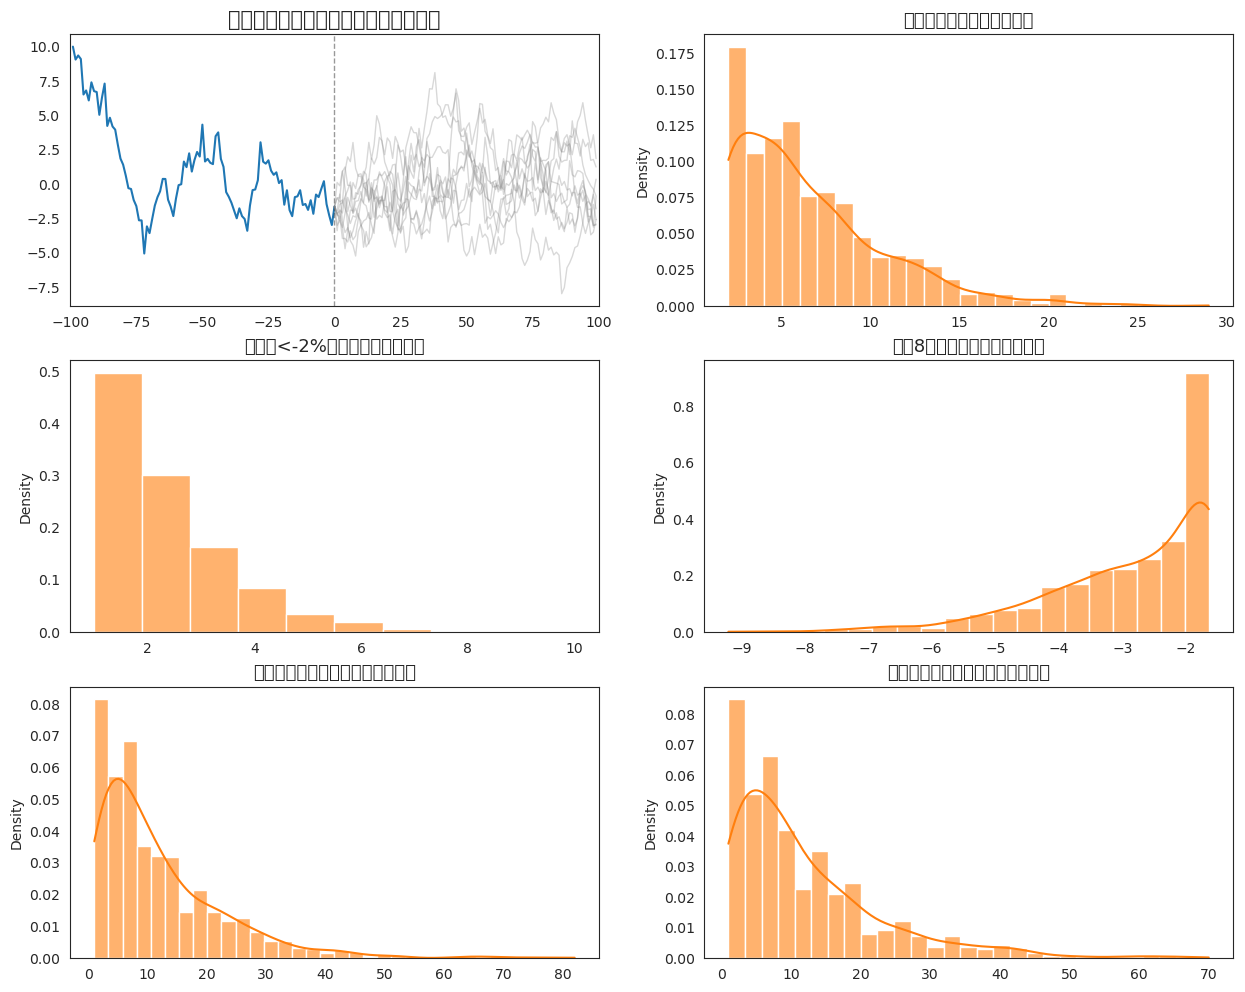

In [7]:
def plot_extended_Wecker(post_samples, initial_path, N, ax):
    """
    绘制扩展 Wecker 的预测分布
    """
    # 选择样本
    index = np.random.choice(np.arange(len(post_samples['rho'])), N + 1, replace=False)
    rho_sample = post_samples['rho'][index]
    sigma_sample = post_samples['sigma'][index]

    # 存储结果
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)

    # 绘图
    ax[0, 0].set_title("初始路径和从后验抽样模拟的未来路径", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # 模拟未来路径
    for n in range(N):
        sim_path = AR1_simulate(rho_sample[n], sigma_sample[n], initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n % (N / 10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
        
    # 返回 next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.6, color=colors[1], label='从后验分布抽样')
    ax[0, 1].set_title("下一次衰退时间的预测分布", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=.9, alpha=.6, color=colors[1], label='从后验分布抽样')
    ax[1, 0].set_title(r"增长率<-2%的停止时间预测分布", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.6, color=colors[1], label='从后验分布抽样')
    ax[1, 1].set_title("未来8个周期最小值的预测分布", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.6, color=colors[1], label='从后验分布抽样')
    ax[2, 0].set_title("下一个正向转折点时间的预测分布", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.6, color=colors[1], label='从后验分布抽样')
    ax[2, 1].set_title("下一个负向转折点时间的预测分布", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.show()

## 比较

最后，我们将原始的Wecker方法和从后验分布中抽取参数值的扩展方法一起绘制，以比较在参数实际不确定时假装知道参数值所产生的差异。

/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/runner/miniconda3/envs/quantecon/lib/python3.12/site-packa

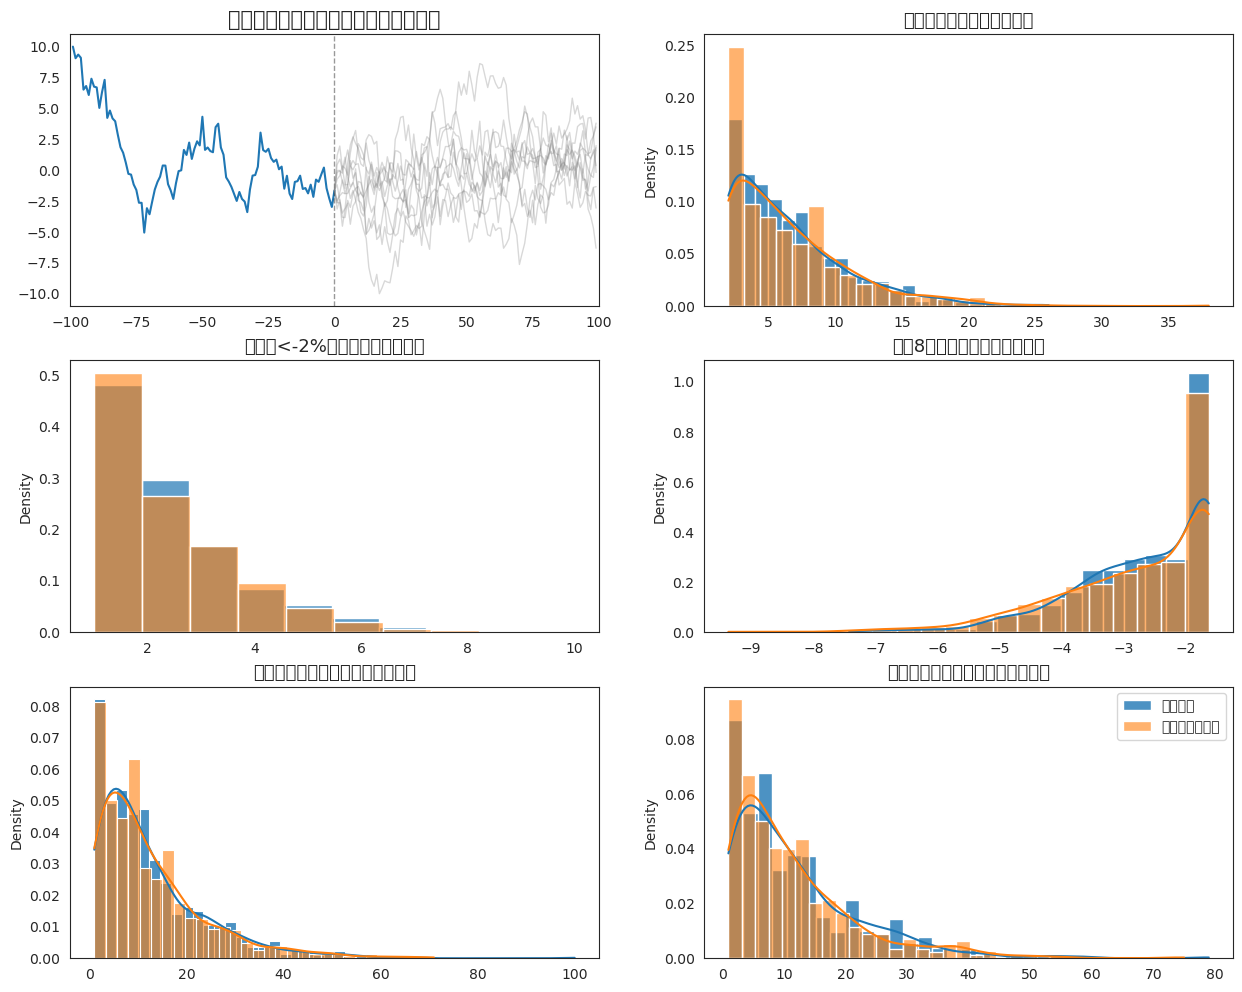

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
ax[0, 0].clear()
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.legend()
plt.show()